In [1]:
import os
os.environ['PYTHONHASHSEED']=str(14)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import time
import numpy as np
np.random.seed(14)
import pandas as pd
import gym
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape
action_size = env.action_space.n

In [3]:
def create_dqn_model():
    model = Sequential()
    model.add(Dense(64, input_shape=state_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
    return model

In [4]:
def train_agent(env,episodes,batch_size,gamma,epsilon_decay):
    agent = create_dqn_model()
    target_agent = create_dqn_model()
    memory = []
    reward_list = []
    mean_reward_list = []
    epsilon = 1
    for i in range(episodes):
        start_time = time.time()
        # Reduce the epsilon for each episode with the epsilon decay factor for 0.998
        state = env.reset()
        done = False
        total_rewards = 0
        while not done: 
            # Take action based on epsilon value, either random or based on DQN
            action = env.action_space.sample() if np.random.random() < epsilon else np.argmax(target_agent.predict_on_batch(state.reshape(1, -1))[0])
            next_state, reward, done, _ = env.step(action) 

            # Append the current iteration parameters to memory
            memory.append((state,action,reward,done,next_state))
            
            # If memory exceeds the limit pop the earlier values
            if len(memory) > 10000:
                memory.pop(0)

            state = next_state
            total_rewards += reward

            # Fit the DQN model based on the batch size from data in the memory
            if len(memory) >= batch_size * 2:
                indexes = list(np.random.choice(len(memory)-1, batch_size-1, replace=False))
                indexes.append(len(memory)-1)
                train_state = np.array([memory[i][0] for i in indexes]).reshape([batch_size,8])    
                train_action = np.array([memory[i][1] for i in indexes])
                train_reward = np.array([memory[i][2] for i in indexes])
                train_done = np.array([memory[i][3] for i in indexes])
                train_next_state = np.array([memory[i][4] for i in indexes]).reshape([batch_size,8])

                target_action = agent.predict_on_batch(train_state)
                target_action[np.arange(len(target_action)), train_action] = train_reward
                target_action[~train_done, train_action[~train_done]] += gamma * np.max(target_agent.predict_on_batch(train_next_state[~train_done]), axis=1)

                agent.fit(train_state, target_action,verbose=0)
                
                if len(memory)%1000 == 0:
                    target_agent.set_weights(agent.get_weights())       
        reward_list.append(total_rewards)
        mean_reward_list.append(np.mean(reward_list[-100:]))
        end_time = time.time()
        episode_time =  end_time - start_time      
        print(f'Episode {i} with Epsilon {epsilon:.3f} Completed with Reward {int(total_rewards)} in {episode_time:.1f} seconds. Mean Reward for 100 Episodes: {int(np.mean(reward_list[-100:]))}')
        epsilon = epsilon * epsilon_decay if epsilon > 0.01 else epsilon
        if all(i >= 200 for i in reward_list[-25:]):
            print(f'Converged after {i} Episodes')
            break
    output_df = pd.DataFrame({'Episode':list(range(len(reward_list))),'Rewards':reward_list,'Average Rewards':mean_reward_list})
    return target_agent,output_df

In [5]:
def run_trained_agent(env,agent,episodes):
    memory = []
    reward_list = []
    mean_reward_list = []
    for i in range(episodes):
        state = env.reset()
        done = False
        total_rewards = 0
        while not done: 
            action = np.argmax(agent.predict(state.reshape(1, -1))[0])
            next_state, reward, done, _ = env.step(action) 
            state = next_state
            total_rewards += reward
        reward_list.append(total_rewards)
        mean_reward_list.append(np.mean(reward_list[-100:]))
        print(f'Episode {i} Completed with Reward {int(total_rewards)}. Mean Reward for Last 100 Episodes: {int(np.mean(reward_list[-100:]))}')
    output_df = pd.DataFrame({'Episode':list(range(episodes)),'Rewards':reward_list,'Average Rewards':mean_reward_list})
    return output_df

In [6]:
def create_plot(df):
    fig1 = plt.figure()
    plt.plot(df["Episode"],df["Rewards"])
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    
    fig2 = plt.figure()
    plt.plot(df["Episode"],df["Average Rewards"])
    plt.xlabel("Episodes")
    plt.ylabel("Average Rewards")
    plt.show()
    return (fig1,fig2)

In [7]:
batch_size=16
gamma=0.99
epsilon_decay = 0.998
Trained_Agent,Training_Output = train_agent(env,2000,batch_size,gamma,epsilon_decay)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 0 with Epsilon 1.000 Completed with Reward -196 in 0.4 seconds. Mean Reward for 100 Episodes: -196
Episode 1 with Epsilon 0.998 Completed with Reward -374 in 0.3 seconds. Mean Reward for 100 Episodes: -285
Episode 2 with Epsilon 0.996 Completed with Reward -89 in 0.3 seconds. Mean Reward for 100 Episodes: -219
Episode 3 with Epsilon 0.994 Completed with Reward -115 in 0.2 seconds. Mean Reward for 100 Episodes: -193
Episode 4 with Epsilon 0.992 Completed with Reward -197 in 0.3 seconds. Mean Reward for 100 Episodes: -194
Episode 5 with Epsilon 0.990 Completed with Reward -87 in 0.2 seconds. Mean Reward for 100 Episodes: -176
Episode 6 with Epsilon 0.988 Completed with Reward -112 in 0.3 seconds. Mean Reward for 100 Episodes: -167
Episode 7 with Epsilon 0.986 Completed with Reward -58 in 0.2 seconds. Mean Reward for 100 Episodes: -153
Episode 8 with Epsilon 0.984 Completed with Reward -341 in 0.5 seconds. Mean Reward for 100 Episodes: -174
Episode 9 with Epsilon 0.982 Completed w

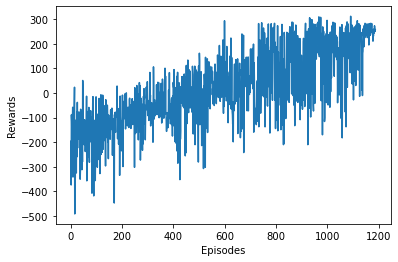

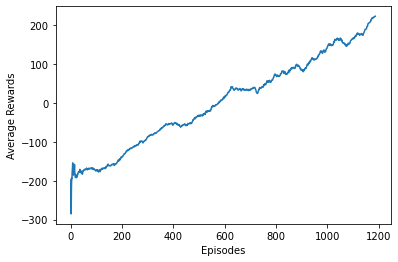

In [8]:
training_reward_plot,training_mean_reward_plot = create_plot(Training_Output)
training_reward_plot.savefig("Training_Reward_Plot.png")
training_mean_reward_plot.savefig("Training_Mean_Reward_Plot.png")

In [9]:
Trained_Output = run_trained_agent(env,Trained_Agent,200)

Episode 0 Completed with Reward 221. Mean Reward for Last 100 Episodes: 221
Episode 1 Completed with Reward 250. Mean Reward for Last 100 Episodes: 235
Episode 2 Completed with Reward 252. Mean Reward for Last 100 Episodes: 241
Episode 3 Completed with Reward -18. Mean Reward for Last 100 Episodes: 176
Episode 4 Completed with Reward 270. Mean Reward for Last 100 Episodes: 195
Episode 5 Completed with Reward 134. Mean Reward for Last 100 Episodes: 185
Episode 6 Completed with Reward 150. Mean Reward for Last 100 Episodes: 180
Episode 7 Completed with Reward 238. Mean Reward for Last 100 Episodes: 187
Episode 8 Completed with Reward 276. Mean Reward for Last 100 Episodes: 197
Episode 9 Completed with Reward 285. Mean Reward for Last 100 Episodes: 206
Episode 10 Completed with Reward 222. Mean Reward for Last 100 Episodes: 207
Episode 11 Completed with Reward 262. Mean Reward for Last 100 Episodes: 212
Episode 12 Completed with Reward 103. Mean Reward for Last 100 Episodes: 204
Episode 1

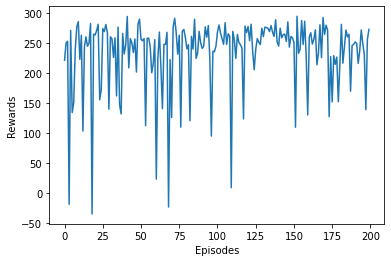

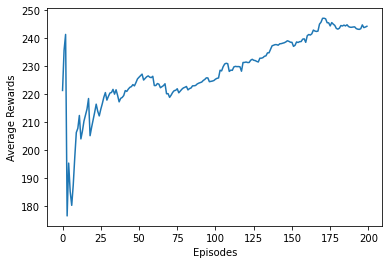

In [10]:
Trained_reward_plot,Trained_mean_reward_plot = create_plot(Trained_Output)
Trained_reward_plot.savefig("Trained_Reward_Plot.png")
Trained_mean_reward_plot.savefig("Trained_Mean_Reward_Plot.png")